# Regression Script LOO CV
## Partial Least Squares Regression

### Florian Beyer
### 2020-08-05
### V0.2

Quellen: 
- https://nirpyresearch.com/partial-least-squares-regression-python/
variable importance: https://github.com/scikit-learn/scikit-learn/issues/7050

In [20]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets
from joblib import dump, load
from operator import itemgetter

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

import datetime

import seaborn as sns

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

settings_sns = {'axes.facecolor': 'white',
                'axes.edgecolor': '0',
                'axes.grid': True,
                'axes.axisbelow': True,
                'axes.labelcolor': '.15',
                'figure.facecolor': 'white',
                'grid.color': '.8',
                'grid.linestyle': '--',
                'text.color': '0',
                'xtick.color': '0',
                'ytick.color': '0',
                'xtick.direction': 'in',
                'ytick.direction': 'in',
                'lines.solid_capstyle': 'round',
                'patch.edgecolor': 'w', 
                'patch.force_edgecolor': True,
                'image.cmap': 'Greys',
                'font.family': ['serif'],
                'font.sans-serif': ['Arial', 'Liberation Sans', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif'],
                'xtick.bottom': True,
                'xtick.top': True,
                'ytick.left': True,
                'ytick.right': True,
                'axes.spines.left': True,
                'axes.spines.bottom': True,
                'axes.spines.right': True,
                'axes.spines.top': True}

In [39]:
# data input

# the remote sensing image you want to classify
img_RS = 'N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/raster/005_stacks/2019_LH_pre_stack_24bands.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/vector/2019_Felddaten.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'FM'

results_path = 'N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/results/plsr/'
name = '2020_LH_pre_'

# save path, predicted image
prediction_map = results_path + name + attribute +'.tif'

comp_plot = results_path + name + attribute+'_components.pdf'

validation_plot = results_path + name + attribute+'_regressionplot.pdf'

results_txt = results_path + name + attribute+'.txt'

# save path, trained model
#save_model = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\PLSR_model.joblib'


In [40]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['Name', 'X', 'Y', 'Z', 'FM', 'TM']


In [41]:
# prepare results text file:

print('PLSR - LOOCV Regression', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('samples shape: {}'.format(field) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('predicted regression image: {}'.format(prediction_map) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))


In [42]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [43]:
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))


Image extent: 916 x 166 (row x col)
Number of Bands: 24


In [44]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_Float32)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


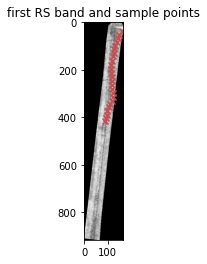

In [45]:
# Display image and Training data

plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
roi_positions = np.where(roi > 0)
plt.scatter(roi_positions[1], roi_positions[0], marker='x', c='r' )
plt.title('first RS band and sample points')


plt.show()


In [46]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))# Subset the image dataset with the training image = X
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

We have 25 training samples


In [47]:
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

In [48]:
features = pd.DataFrame(X)

band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

features.columns = band_names

print('The shape of our features is:', features.shape)
print('The number of Spectra is:', features.shape[0])
print('The number of bands is:', features.shape[1])

features['value'] = y

features.head()


The shape of our features is: (25, 24)
The number of Spectra is: 25
The number of bands is: 24


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_16,Band_17,Band_18,Band_19,Band_20,Band_21,Band_22,Band_23,Band_24,value
0,113.0,100.0,61.0,0.057574,0.071698,0.148178,0.181828,4.877329,58.409283,0.234739,...,0.101969,0.434391,-0.017265,0.117088,-0.085526,110.0,78.351768,4.921875,226.990326,160.0
1,102.0,97.0,57.0,0.063913,0.055820,0.175657,0.248511,4.994516,40.052219,0.271267,...,0.171756,0.633162,-0.030406,0.148526,-0.035211,22.0,72.006943,4.828125,185.129974,150.0
2,112.0,103.0,66.0,0.063320,0.055141,0.161841,0.220738,4.796968,43.553509,0.256472,...,0.153948,0.600255,-0.030075,0.146602,-0.060403,17.0,95.420120,5.328125,280.905884,70.0
3,125.0,112.0,68.0,0.078693,0.099212,0.179207,0.227386,4.541433,31.345501,0.301933,...,0.118494,0.392452,-0.023985,0.131049,-0.076923,11.0,104.484451,5.468750,309.699768,180.0
4,99.0,104.0,55.0,0.073161,0.056719,0.219834,0.279301,3.861754,32.651554,0.179860,...,0.119140,0.662406,-0.036240,0.148257,0.033784,31.0,68.124886,4.578125,159.020782,270.0


In [49]:
# Labels are the values we want to predict
labels = np.array(features['value'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('value', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

print('Training Features Shape: ', features.shape)
print('Training Labels Shape: ', labels.shape)

Training Features Shape:  (25, 24)
Training Labels Shape:  (25,)


Suggested number of components:  3


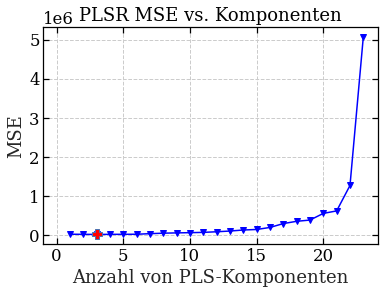

In [50]:
mse = []
component = np.arange(1, features.shape[1])

for i in component:
    pls = PLSRegression(n_components=i)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=X.shape[0])

    mse.append(mean_squared_error(y, y_cv))

   # comp = 100*(i+1)/40


    # Calculate and print the position of minimum in MSE
msemin = np.argmin(mse)
suggested_comp = msemin+1
print("Suggested number of components: ", suggested_comp)
print("Suggested number of components: {}".format(suggested_comp), file=open(results_txt, "a"))

with plt.style.context(('ggplot')):
    sns.set(rc=settings_sns, font_scale=1.5)
    plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
    plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
    plt.xlabel('Anzahl von PLS-Komponenten')
    plt.ylabel('MSE')
    plt.title('PLSR MSE vs. Komponenten')
    plt.xlim(left=-1)
    
    plt.savefig(comp_plot,bbox_inches='tight')

plt.show()

In [51]:
# Define PLS object with optimal number of components
pls_opt = PLSRegression(n_components=msemin+1)

# Fir to the entire dataset
pls_opt.fit(X, y)
y_c = pls_opt.predict(X)

# Cross-validation
y_cv = cross_val_predict(pls_opt, X, y, cv=X.shape[0], n_jobs=-1, verbose=2)

# Calculate scores for calibration and cross-validation
score_c = r2_score(y, y_c)
score_cv = r2_score(y, y_cv)

# Calculate mean squared error for calibration and cross validation
mse_c = mean_squared_error(y, y_c)
mse_cv = mean_squared_error(y, y_cv)


print('R2 calib: %5.3f'  % score_c)
print('R2 LOOCV: %5.3f'  % score_cv)
print('MSE calib: %5.3f' % mse_c)
print('MSE LOOCV: %5.3f' % mse_cv)

print("-----------------------", file=open(results_txt, "a"))
print('R2 calib: %5.3f'  % score_c, file=open(results_txt, "a"))
print('R2 LOOCV: %5.3f'  % score_cv, file=open(results_txt, "a"))
print('MSE calib: %5.3f' % mse_c, file=open(results_txt, "a"))
print('MSE LOOCV: %5.3f' % mse_cv, file=open(results_txt, "a"))


R2 calib: 0.787
R2 LOOCV: 0.492
MSE calib: 5769.810
MSE LOOCV: 13754.796


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [52]:
print("-----------------------", file=open(results_txt, "a"))
print("band importance", file=open(results_txt, "a"))

# function for variable importance
def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

importance = vip(pls_opt)

imp = {}
for i in range(features.shape[1]):
    print('Band {}: {}'.format(i+1, importance[i]))
    print('Band {}: {}'.format(i+1, importance[i]), file=open(results_txt, "a"))
    imp['Band{}'.format(i+1)] = importance[i]




Band 1: 1.093219086628697
Band 2: 0.43742236443544386
Band 3: 0.7914312430579521
Band 4: 0.326389521840244
Band 5: 0.8867331732612398
Band 6: 0.9925587116394228
Band 7: 1.1754884712700358
Band 8: 1.436255489634415
Band 9: 0.6034669438612419
Band 10: 0.8730873999044519
Band 11: 1.3457815698427018
Band 12: 0.8645465013034223
Band 13: 0.9071823954037701
Band 14: 1.6028384310280255
Band 15: 1.2081698128982028
Band 16: 1.1086811626660322
Band 17: 1.1679072653105005
Band 18: 0.9080144410388962
Band 19: 0.8797464620549392
Band 20: 1.3990154645282848
Band 21: 0.37541640274458327
Band 22: 0.8501726071924788
Band 23: 0.6756580395526796
Band 24: 0.8115949984941528


In [53]:
print("-----------------------", file=open(results_txt, "a"))
print("sorted band importance", file=open(results_txt, "a"))
sorted_imp = dict(sorted(imp.items(), key=itemgetter(1), reverse=True))

for i in sorted_imp:
    print('{}: {}'.format(i, sorted_imp[i]))

for i in sorted_imp:
    print('{}: {}'.format(i, sorted_imp[i]), file=open(results_txt, "a"))
print("-----------------------", file=open(results_txt, "a"))

Band14: 1.6028384310280255
Band8: 1.436255489634415
Band20: 1.3990154645282848
Band11: 1.3457815698427018
Band15: 1.2081698128982028
Band7: 1.1754884712700358
Band17: 1.1679072653105005
Band16: 1.1086811626660322
Band1: 1.093219086628697
Band6: 0.9925587116394228
Band18: 0.9080144410388962
Band13: 0.9071823954037701
Band5: 0.8867331732612398
Band19: 0.8797464620549392
Band10: 0.8730873999044519
Band12: 0.8645465013034223
Band22: 0.8501726071924788
Band24: 0.8115949984941528
Band3: 0.7914312430579521
Band23: 0.6756580395526796
Band9: 0.6034669438612419
Band2: 0.43742236443544386
Band21: 0.37541640274458327
Band4: 0.326389521840244


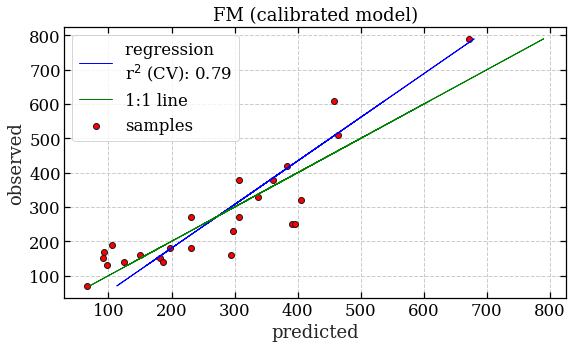

In [54]:
# quality of calibration model

# Fit a line to the CV vs response
z = np.polyfit(y, y_c, 1)
with plt.style.context(('ggplot')):
    sns.set(rc=settings_sns, font_scale=1.5)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_c, y, c='red', edgecolors='k')
    #Plot the best fit line
    ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
    #Plot the ideal 1:1 line
    ax.plot(y, y, color='green', linewidth=1)
    plt.title(attribute + ' (calibrated model)')
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.legend(['regression \nr$^{2}$ (CV): '+str(round(score_c,2)),'1:1 line','samples'])

    #plt.savefig(validation_plot,bbox_inches='tight')

    plt.show()

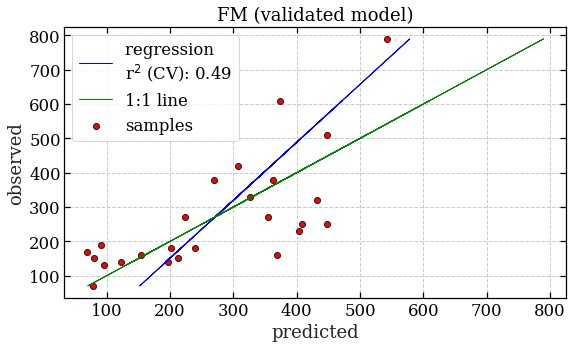

In [55]:
# quality of LOOCV validated model

# Fit a line to the CV vs response
z = np.polyfit(y, y_cv, 1)
with plt.style.context(('ggplot')):
    sns.set(rc=settings_sns, font_scale=1.5)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_cv, y, c='red', edgecolors='k')
    #Plot the best fit line
    ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
    #Plot the ideal 1:1 line
    ax.plot(y, y, color='green', linewidth=1)
    plt.title(attribute + ' (validated model)')
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.legend(['regression \nr$^{2}$ (CV): '+str(round(score_cv,2)),'1:1 line','samples'])

    #plt.savefig(validation_plot,bbox_inches='tight')

    plt.show()

In [56]:
# Calculate the absolute errors
errors = abs(y_cv-y)
# Print out the mean absolute error (mae)

# Print out the mean absolute error (mae)


print('-------------')
print('n of the test data: {}'.format(len(labels)))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)))
print('-------------')
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)))

print('-------------', file=open(results_txt, "a"))
print('n of the test data: {}'.format(len(labels)), file=open(results_txt, "a"))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)), file=open(results_txt, "a"))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)), file=open(results_txt, "a"))
print('-------------', file=open(results_txt, "a"))
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)), file=open(results_txt, "a"))

mse = mean_squared_error(y, y_cv)
print('Mean squared error: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(np.sqrt(mse)))
print('RPD: {:.2f} | How often does RMSE of Prediction fit in the Standard Deviation of the samples'.format(np.std(labels)/np.sqrt(mse)))

print('Mean squared error: {:.2f}'.format(mse), file=open(results_txt, "a"))
print('RMSE: {:.2f}'.format(np.sqrt(mse)), file=open(results_txt, "a"))
print('RPD: {:.2f}| How often does RMSE of Prediction fit in the Standard Deviation of the samples'.format(np.std(labels)/np.sqrt(mse)), file=open(results_txt, "a"))


'''
To put our predictions in perspective, we can calculate an accuracy using
the mean average percentage error subtracted from 100 %.
'''
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('mean absolute percentage error (MAPE): {:.2f} %'.format(np.mean(mape)))
print('accuracy (100 % - mape): {:.2f} %'.format(accuracy))


print('-------------')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(y, y_cv)))


print('mean absolute percentage error (MAPE): {:.2f} %'.format(np.mean(mape)), file=open(results_txt, "a"))
print('accuracy (100 % - mape): {:.2f} %'.format(accuracy), file=open(results_txt, "a"))


print('-------------', file=open(results_txt, "a"))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(y, y_cv)), file=open(results_txt, "a"))


-------------
n of the test data: 25
Mean of the variable: 273.20
Standard deviation of the variable: 164.63
-------------
Mean Absolute Error: 168.81
Mean squared error: 13754.80
RMSE: 117.28
RPD: 1.40 | How often does RMSE of Prediction fit in the Standard Deviation of the samples
mean absolute percentage error (MAPE): 77.10 %
accuracy (100 % - mape): 22.90 %
-------------
Coefficient of determination r²: 0.49


In [21]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (916, 165, 24) to (151140, 24)


In [22]:
prediction_ = pls_opt.predict(img_as_array)

In [23]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (916, 165)


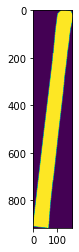

In [24]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

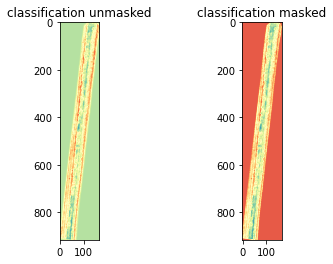

In [25]:
# mask classification an plot

prediction_ = prediction*mask

plt.subplot(121)
plt.imshow(prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

In [26]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/results/plsr/2020_LH_pre_FM.tif


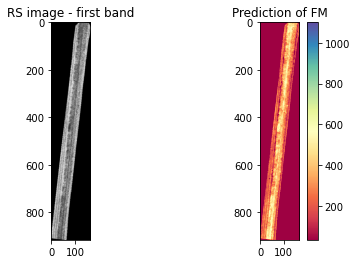

In [27]:
# Display images


plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(prediction_, cmap=plt.cm.Spectral, vmin= y.min(), vmax=y.max())
plt.title('Prediction of ' + attribute)
plt.colorbar()

plt.show()